In [1]:
import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

2024-02-13 10:35:00.498272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 10:35:00.578867: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 10:35:00.581931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/redo/Project_Bertha/bertha_ng/lib:/usr/local/libxc:/home/redo/Sources/reposMD/inchi/INCHI-1-API/INCH

In [2]:
def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF","ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    
howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "ZORA" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
BH76 No data found for this dataset

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  MCONF
Number of samples:  51
Number of basic descriptors:  51

Reading dataset:  PCONF21
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  SCONF
Number of samples:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method

for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


                         BARRIER_HEIGHTS  ,  0  ,    6.410  ,   PBE0  ,   21.488
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   ZORA  ,   14.651
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    1.137  ,   PBE0  ,    5.268
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
       INTRAMOLECULAR_INTERACTIONS_ICONF  ,  2  ,    0.450  ,    PBE  ,    1.496
       INTRAMOLECULAR_INTERACTIONS_IDISP  ,  2  ,    4.154  ,    PBE  ,   11.849
       INTRAMOLECULAR_INTERACTIONS_MCONF  ,  1  ,    0.480  ,   ZORA  ,    1.895
     INTRAMOLECULAR_INTERACT

In [32]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

moldescriptors_featues, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(moldescriptors_featues, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_Two_Electron_Energy  
                    PBE_Nuclear_Repulsion 1.00
                  PBE_One_Electron_Energy 1.00
                 PBE0_Two_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                   ZORA_Nuclear_Repulsion 1.00
                 ZORA_One_Electron_Energy 1.00
                 ZORA_Two_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
                TPSSh_One_Electron_Energy 1.00
                TPSSh_Two_Electron_Energy 1.00
PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    ZORA_Potential_Energy 0.99
                   TPSSh_Potential_Energy 0.99
PBE_FINAL_SINGLE_POINT_ENERGY  
           PBE0_FINAL_SINGLE_POINT_ENERGY 1.00
           ZORA_FINAL_SINGLE_POINT_ENERGY 1.00
          TPSSh_FINAL_SINGLE_POINT_ENERGY 1.00
PBE_Kinetic_Energy  
                      PBE0_Kinetic_Energy 0.99
                      ZORA_Kinetic_Energy 0.99
     

In [41]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   ZORA_Kinetic_Energy
2   ZORA_One_Electron_Energy
3   TPSSh_Kinetic_Energy
4   TPSSh_Dispersion_correction
5   PBE0_One_Electron_Energy
6   ZORA_E(X)
7   TPSSh_E(X)
8   TPSSh_FINAL_SINGLE_POINT_ENERGY
9   PBE0_FINAL_SINGLE_POINT_ENERGY
10   ZORA_E(C)
11   PBE0_Two_Electron_Energy
12   TPSSh_Two_Electron_Energy
13   ZORA_Two_Electron_Energy
14   PBE0_Nuclear_Repulsion
15   PBE0_E(C)
16   PBE_Nuclear_Repulsion
17   TPSSh_One_Electron_Energy
18   ZORA_Dispersion_correction
19   PBE0_Dispersion_correction
20   PBE0_Kinetic_Energy
21   TPSSh_Potential_Energy
22   TPSSh_Nuclear_Repulsion
23   ZORA_Potential_Energy
24   PBE0_Potential_Energy
25   PBE0_E(X)
26   TPSSh_E(C)
27   PBE_One_Electron_Energy
28   ZORA_FINAL_SINGLE_POINT_ENERGY
29   ZORA_Nuclear_Repulsion


In [42]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_FINAL_SINGLE_POINT_ENERGY
2 PBE_E(C)
3 PBE_E(X)
4 PBE_Two_Electron_Energy
5 PBE_Potential_Energy
6 PBE_Kinetic_Energy
7 PBE_Dispersion_correction


In [43]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
moldescriptors_featues, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(moldescriptors_featues, columns=features_names)

Correlation matrix


<AxesSubplot:>

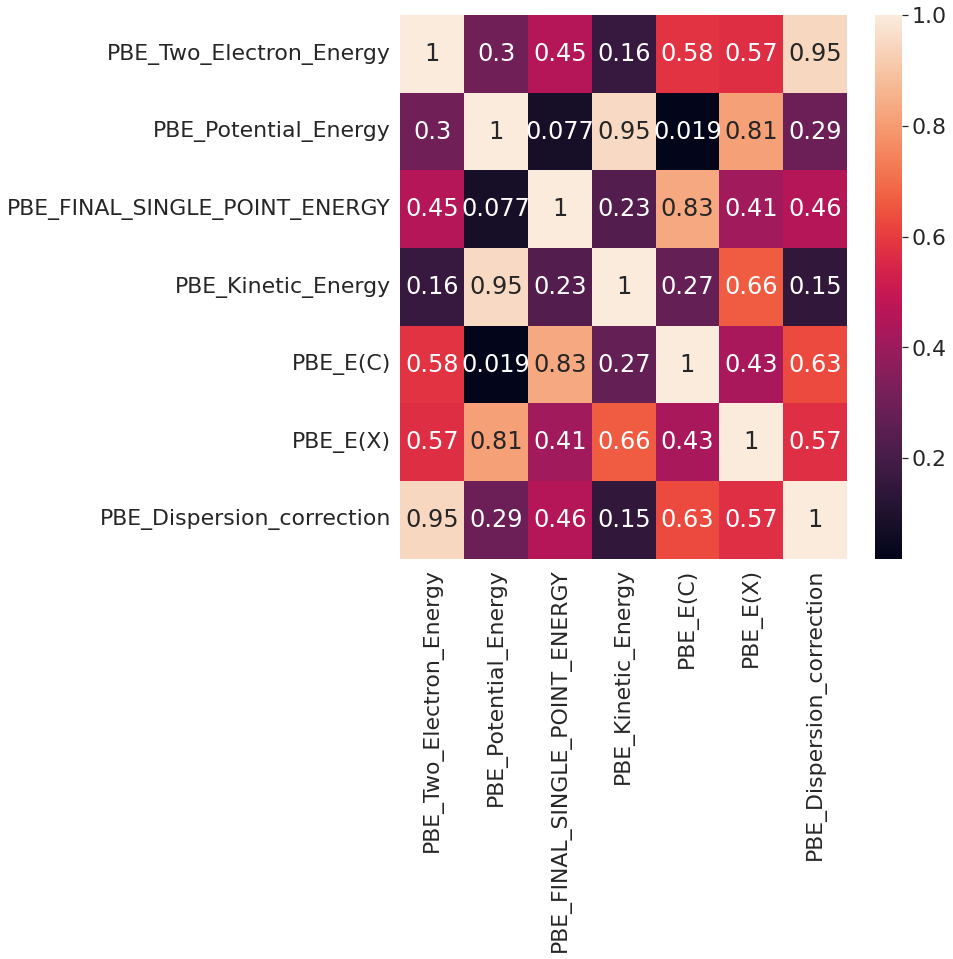

In [44]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)